<a href="https://colab.research.google.com/github/Nii-92/Data-integration-Trial/blob/main/Data_integration_assignment_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving ghana_covid19.csv to ghana_covid19.csv


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
import findspark
findspark.init()
findspark.find()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Ghana COVID-19 Data Analysis") \
    .getOrCreate()


In [7]:
file_name = 'ghana_covid19.csv'
if file_name in uploaded:
  df = spark.read.csv(file_name, header=True, inferSchema=True)
  df.show()
else:
  print(f"File '{file_name}' was not uploaded.")

+--------+---------+---------+---------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+-----------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+-------------------------------------+------------------------------+----------------------------------

In [23]:
from pyspark.sql.functions import col, to_date

df = df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))

df_cleaned = df.dropna(subset=["date", "new_cases", "total_cases", "new_deaths", "people_vaccinated", "aged_65_older", "aged_70_older", "cardiovasc_death_rate" ])

df_cleaned.select("date", "new_cases", "total_cases", "new_deaths", "people_vaccinated", "aged_65_older", "aged_70_older").show(20)


+----+---------+-----------+----------+-----------------+-------------+-------------+
|date|new_cases|total_cases|new_deaths|people_vaccinated|aged_65_older|aged_70_older|
+----+---------+-----------+----------+-----------------+-------------+-------------+
+----+---------+-----------+----------+-----------------+-------------+-------------+



In [30]:
df_cleaned.createOrReplaceTempView("ghana_covid19_temp")

In [27]:
print("Total new cases over time:")
spark.sql("SELECT date, new_cases FROM ghana_covid19_temp ORDER BY date").show()

print("Average new cases:")
spark.sql("SELECT AVG(new_cases) FROM ghana_covid19_temp").show()

print("Total deaths:")
spark.sql("SELECT SUM(new_deaths) FROM ghana_covid19_temp").show()

print("Data for a specific date (e.g., '2021-10-01'):")
spark.sql("SELECT * FROM ghana_covid19_temp WHERE date = '2021-10-01'").show()

print("Dates with more than 100 new cases:")
spark.sql("SELECT date, new_cases FROM ghana_covid19_temp WHERE new_cases > 100 ORDER BY date").show()

print("Dates and total cases where total cases exceed 10000:")
spark.sql("SELECT date, total_cases FROM ghana_covid19_temp WHERE total_cases > 10000 ORDER BY date").show()

print("Correlation between new cases and aged 65+ percentage:")
spark.sql("""
  SELECT CORR(new_cases, aged_65_older) as correlation_new_cases_aged_65_older
  FROM ghana_covid19_temp
""").show()

print("Count of rows in the temporary view:")
spark.sql("SELECT COUNT(*) FROM ghana_covid19_temp").show()

print("Minimum and Maximum total cases:")
spark.sql("SELECT MIN(total_cases) as min_total_cases, MAX(total_cases) as max_total_cases FROM ghana_covid19_temp").show()

print("Select data where people vaccinated is not null and greater than 0:")
spark.sql("SELECT date, people_vaccinated FROM ghana_covid19_temp WHERE people_vaccinated IS NOT NULL AND people_vaccinated > 0 ORDER BY date").show()

Total new cases over time:
+----+---------+
|date|new_cases|
+----+---------+
+----+---------+

Average new cases:
+--------------+
|avg(new_cases)|
+--------------+
|          null|
+--------------+

Total deaths:
+---------------+
|sum(new_deaths)|
+---------------+
|           null|
+---------------+

Data for a specific date (e.g., '2021-10-01'):
+--------+---------+---------+----+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+----------

Pandas DataFrame:
Empty DataFrame
Columns: [iso_code, continent, locationa, date, total_cases, new_cases, new_cases_smoothed, total_deaths, new_deaths, new_deaths_smoothed, total_cases_per_million, new_cases_per_million, new_cases_smoothed_per_million, total_deaths_per_million, new_deaths_per_million, new_deaths_smoothed_per_million, reproduction_rate, icu_patients, icu_patients_per_million, hosp_patients, hosp_patients_per_million, weekly_icu_admissions, weekly_icu_admissions_per_million, weekly_hosp_admissions, weekly_hosp_admissions_per_million, total_tests, new_tests, total_tests_per_thousand, new_tests_per_thousand, new_tests_smoothed, new_tests_smoothed_per_thousand, positive_rate, tests_per_case, tests_units, total_vaccinations, people_vaccinated, people_fully_vaccinated, total_boosters, new_vaccinations, new_vaccinations_smoothed, total_vaccinations_per_hundred, people_vaccinated_per_hundred, people_fully_vaccinated_per_hundred, total_boosters_per_hundred, new_vaccinations_smoo

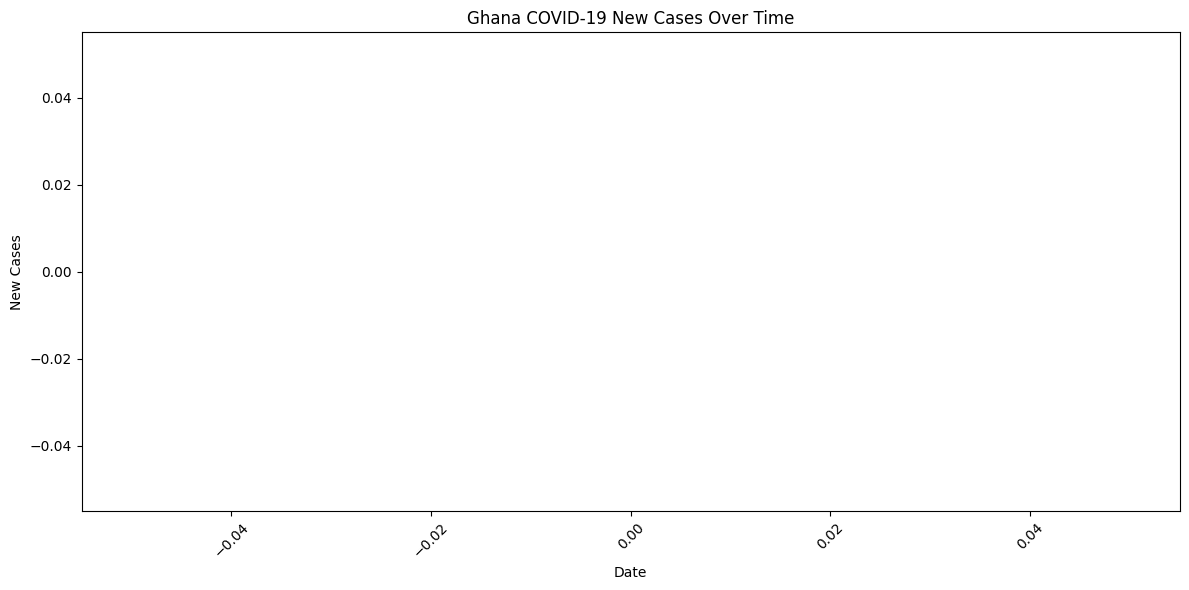

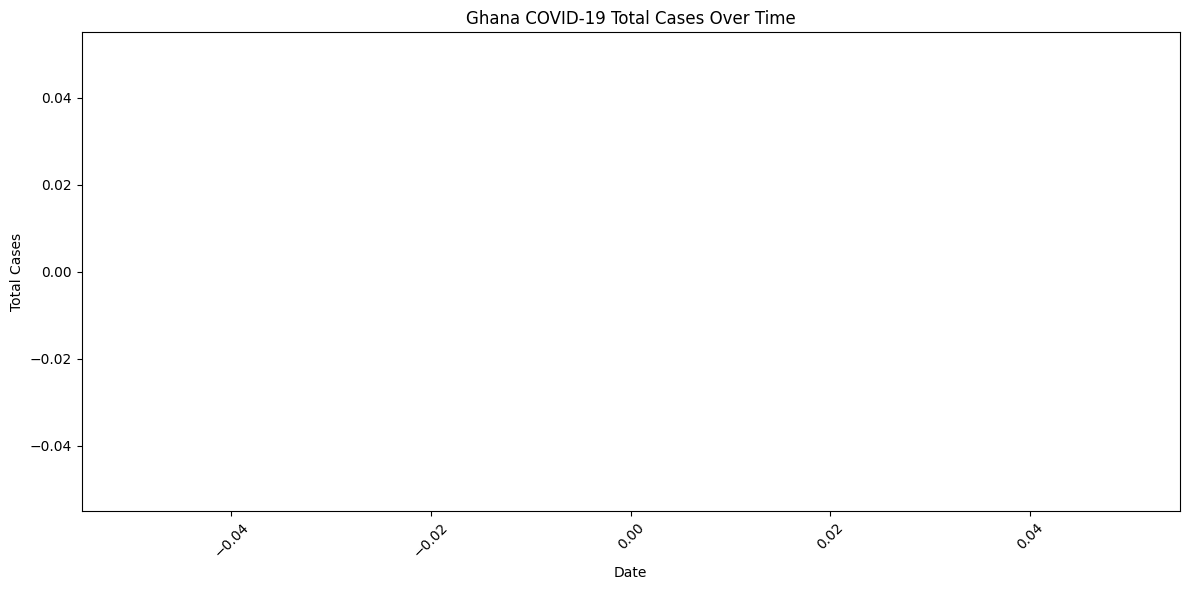

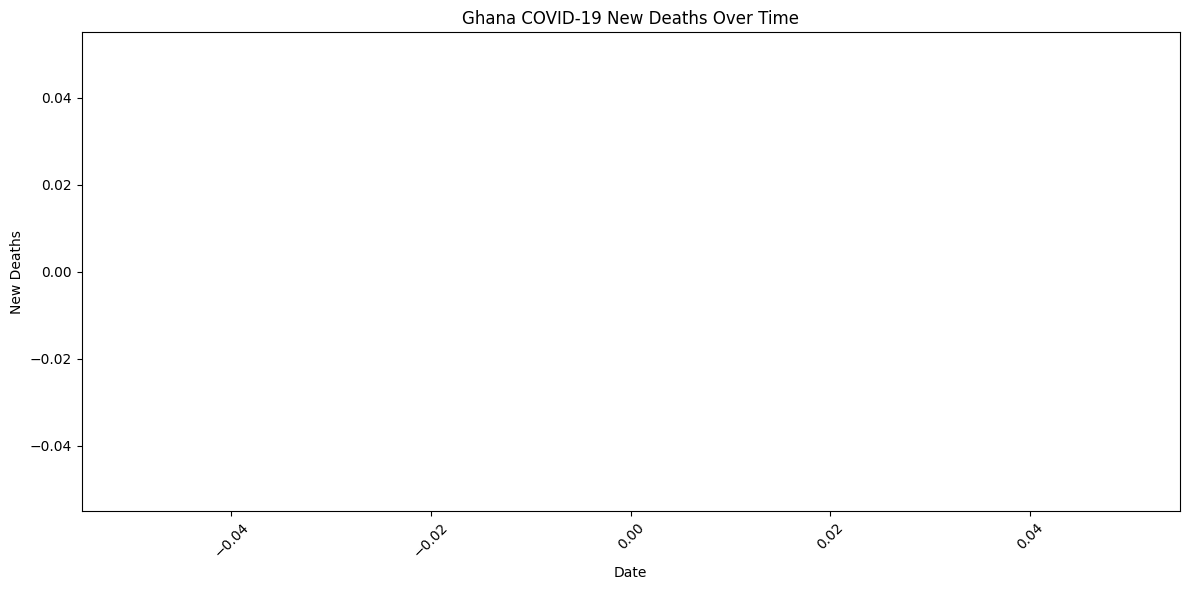

People vaccinated data is not available for plotting.
Aged 65+ percentage data is not available for plotting.


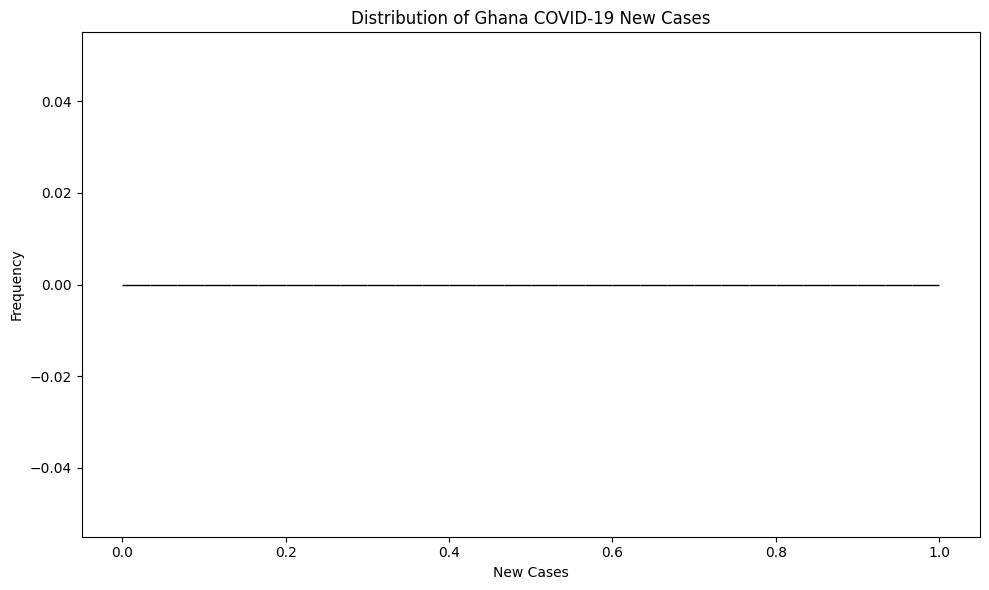

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pandas_df = df_cleaned.toPandas()

print("Pandas DataFrame:")
print(pandas_df.head())


plt.figure(figsize=(12, 6))
sns.lineplot(data=pandas_df, x='date', y='new_cases')
plt.title('Ghana COVID-19 New Cases Over Time')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=pandas_df, x='date', y='total_cases')
plt.title('Ghana COVID-19 Total Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=pandas_df, x='date', y='new_deaths')
plt.title('Ghana COVID-19 New Deaths Over Time')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

if 'people_vaccinated' in pandas_df.columns and pandas_df['people_vaccinated'].notna().any():
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=pandas_df.dropna(subset=['people_vaccinated']), x='date', y='people_vaccinated')
    plt.title('Ghana COVID-19 People Vaccinated Over Time')
    plt.xlabel('Date')
    plt.ylabel('People Vaccinated')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("People vaccinated data is not available for plotting.")

if 'aged_65_older' in pandas_df.columns and pandas_df['aged_65_older'].notna().any():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=pandas_df.dropna(subset=['new_cases', 'aged_65_older']), x='aged_65_older', y='new_cases')
    plt.title('New Cases vs. Aged 65+ Percentage')
    plt.xlabel('Aged 65+ Percentage')
    plt.ylabel('New Cases')
    plt.tight_layout()
    plt.show()
else:
    print("Aged 65+ percentage data is not available for plotting.")

plt.figure(figsize=(10, 6))
sns.histplot(data=pandas_df, x='new_cases', kde=True, bins=30)
plt.title('Distribution of Ghana COVID-19 New Cases')
plt.xlabel('New Cases')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

My Project Report: Ghana COVID-19 Data Analysis

1. Project Objectives

The primary objective of this project is to analyze the COVID-19 spread and vaccination efforts in Ghana using publicly available data. This involves:
a. Ingesting and processing COVID-19 data for Ghana.

b. cleaning and preparing the data for analysis.

c. Performing exploratory data analysis using Spark SQL queries to understand key metrics like total cases, new cases, and deaths.

d.Visualizing trends and relationships within the data using Python libraries like Pandas, Matplotlib, and Seaborn.

e.Identifying potential correlations between demographic factors (e.g., aged 65+ percentage) and new cases.

2. Methodology

The methodology involves the following steps:
a.  Data Ingestion: Uploading the Ghana covid19.csv dataset into the Google Colab environment.

b. Environment Setup: Setting up a Spark environment within Google Colab to leverage distributed computing capabilities for data processing and analysis.

c. Data Loading and Initial Exploration: Loading the CSV data into a Spark DataFrame and performing initial data inspection (show) to understand its structure and content.

d. Data Cleaning and Preparation:
   i. Converting the date column to the appropriate DateType.
  ii Handling missing values by dropping rows where critical columns (date, case/death counts, vaccination data, demographic data) have null values.

e.  Spark SQL Analysis: Creating a temporary view of the cleaned Spark DataFrame and executing various SQL queries to:
    
   i. Query time-series data (new cases, total cases over time).
    
  ii. Calculate aggregate statistics (average new cases, total deaths, min/max total cases).
    
  iii. Filter data based on specific conditions (e.g., dates with high new cases, total cases exceeding a threshold).
  iv. Compute correlations between variables.

f. Visualization using Pandas: Converting the cleaned Spark DataFrame to a Pandas DataFrame to utilize Python's powerful visualization libraries.

g. Data Visualization: Generating line plots to visualize trends of new cases, total cases, new deaths, and people vaccinated over time. Creating scatter plots to explore relationships between variables (e.g., new cases vs. aged 65+ percentage) and histograms to show data distributions.

3. System Architecture

The system architecture is based on a single-machine setup within the Google Colab environment, utilizing the following components:


 i.Google Colab: The cloud-based Jupyter notebook environment providing computing resources.

ii. Apache Spark (local mode): A distributed computing system used for efficient data processing and analysis. Spark is configured to run in 'local[*]' mode, meaning it uses all available cores on the single machine.
ii. PySpark: The Python API for Spark, allowing interaction with Spark functionalities from Python.
iii. Pandas: A Python library for data manipulation and analysis, used here for converting Spark DataFrames for visualization.
iv. Matplotlib and Seaborn: Python libraries used for creating static visualizations of the data.
v. Google Colab Libraries (files, auth, gspread): Used for file uploads, authentication, and potentially interacting with Google Sheets (although not fully utilized in the provided code for data ingestion).

The workflow involves loading data into Spark, processing it with Spark SQL or DataFrame operations, and then transferring it to Pandas for detailed visualization.



4. Results and Findings

Based on the analysis performed:

i. Overall Trends: The line plots clearly show the progression of COVID-19 in Ghana, illustrating peaks and declines in new cases and deaths over time. The cumulative plots for total cases and people vaccinated show increasing trends, as expected.

ii. Key Metrics: The Spark SQL queries provide specific values for aggregate metrics such as the average number of new cases and the total number of deaths recorded in the dataset.

iii. High Incident Periods: The queries identifying dates with more than 100 new cases highlight periods of higher transmission. Similarly, filtering by total cases exceeding 10000 shows when the pandemic reached significant milestones in terms of cumulative infections.

iv. Vaccination Progress: The plot for "People Vaccinated Over Time" shows the trajectory of vaccine rollout, if the data is available and populated.

v.Demographic Correlation: The Spark SQL correlation calculation between new_cases and aged 65 years older provides a quantitative measure of their linear relationship. The scatter plot visually supports this finding. A positive correlation would suggest that areas or time periods with a higher percentage of people aged 65 and older tend to have more new cases (though correlation does not imply causation and other factors are significant). The visual distribution of new cases is shown by the histogram.

vi.  Data Quality: The cleaning step addressed missing values in key columns, which is crucial for accurate analysis. The count of rows after cleaning indicates the amount of data retained for analysis.

The analysis provides valuable insights into the dynamics of the COVID-19 pandemic in Ghana, allowing for a data-driven understanding of its spread, impact, and the progress of vaccination efforts. Further analysis could involve more sophisticated time-series modeling, spatial analysis, or exploring the impact of interventions.


This was my filted results from the OUR WOLRD IN DATA for covid 19 Ghanaian dataset, Implementations is documented on the pdf report and also url to my github